In [10]:
import requests
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import torch
import time

In [41]:
df = pd.read_json('papers.json', orient='records', lines=True)
df = df.drop_duplicates(subset=['title'], keep='first')
# df.to_json('papers.json', orient='records', lines=True)

Get from papers.json

In [2]:
def get_paper_citations(arxiv_id):
    """
    Fetches the citation count for a paper from Semantic Scholar using the arXiv ID.
    
    Args:
        arxiv_id (str): The arXiv ID of the paper (e.g., "2103.00020").
        
    Returns:
        int: Citation count, or None if not found.
    """
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("numCitedBy", 0)
    else:
        return None

# Example usage
arxiv_id = "1706.03762"  # Replace with a valid arXiv ID
citation_count = get_paper_citations(arxiv_id)
print(f"Paper {arxiv_id} has {citation_count} citations.")


Paper 1706.03762 has 112066 citations.


In [40]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for semantic embeddings

# Prepare the text: combine titles and abstracts
df['text'] = df['title'] + ". " + df['summary']

# Generate embeddings
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Save embeddings as a NumPy array
embeddings = np.array(embeddings)
print(f"Generated embeddings shape: {embeddings.shape}")

Batches: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]

Generated embeddings shape: (2699, 384)


Visualize with PCA

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Standardize the embeddings before PCA (important for better results)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform PCA to reduce to 2D or 3D
pca = PCA(n_components=2)  # For 2D visualization, change to 3 for 3D
pca_result = pca.fit_transform(embeddings_scaled)

# Add the PCA results to your DataFrame for easier visualization
df['PCA_x'] = pca_result[:, 0]
df['PCA_y'] = pca_result[:, 1]

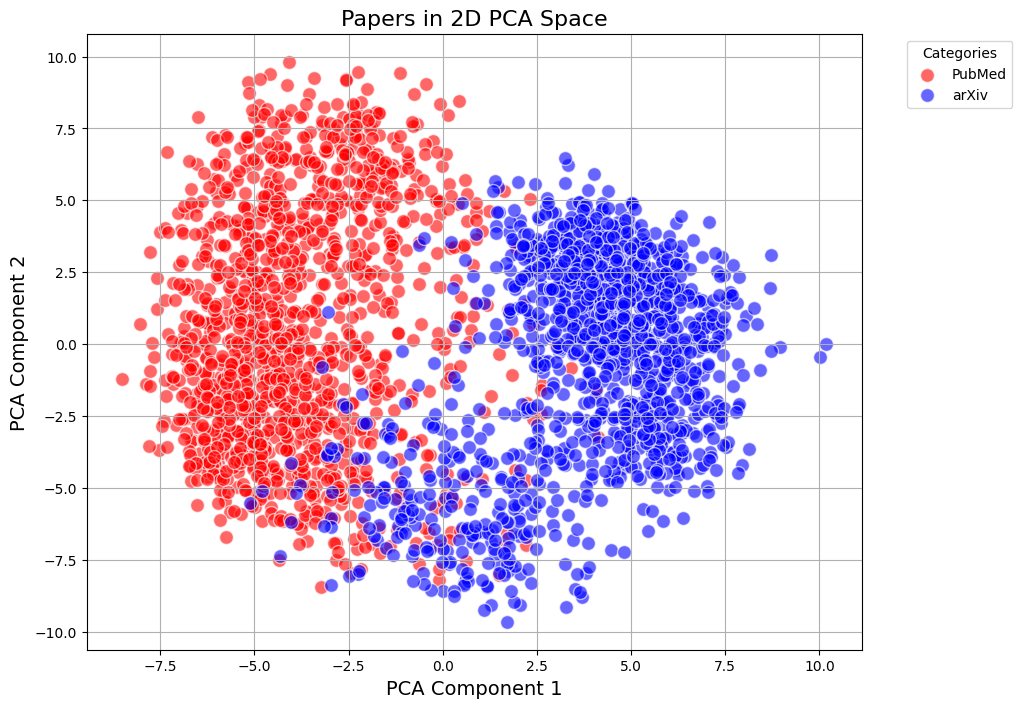

In [44]:
# Define a color map based on categories
category_colors = {
    'PubMed': 'red',
    'arXiv': 'blue'
}


# Plot the papers on a 2D scatter plot
plt.figure(figsize=(10, 8))
for category in df['sourced_from'].unique():
    category_data = df[df['sourced_from'] == category]
    plt.scatter(category_data['PCA_x'], category_data['PCA_y'], 
                label=category, color=category_colors.get(category, 'gray'), alpha=0.6, edgecolors='w', s=100)

# Add labels and title
plt.title("Papers in 2D PCA Space", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Find Papers + Extract Answers

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def search_papers(query, model, embeddings, metadata, top_k=5):
    """
    Search for similar papers using cosine similarity.
    
    Args:
        query (str): Search query text.
        model: Sentence-BERT model for embeddings.
        embeddings: Precomputed paper embeddings.
        metadata: Paper metadata DataFrame.
        top_k (int): Number of top results to return.
    """
    # Encode the query into the same space
    query_embedding = model.encode([query])
    
    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display top results
    papers = []
    for idx in top_indices:
        print(metadata.iloc[idx]['title'])
        papers.append(metadata.iloc[idx]['summary'])
    print('----')
    return papers

In [49]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

qa_model='deepset/roberta-base-squad2'        
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model)

def extract_answer(question, context, min_answer_length=5):
    """
    Extract the most likely answer from a given context with improved handling of longer texts.
    
    Args:
        question (str): Question to answer
        context (str): Context text to extract answer from
        min_answer_length (int): Minimum length of acceptable answer
    
    Returns:
        str: Extracted answer or None
    """
    # Use sliding window approach for longer contexts
    max_length = 512
    stride = 256  # Overlap between windows

    # Tokenize the full context
    full_encoding = qa_tokenizer.encode_plus(
        question, 
        context, 
        return_tensors="pt", 
        max_length=max_length, 
        truncation=True, 
        return_overflowing_tokens=True,
        stride=stride
    )

    best_answer = None
    best_score = -float('inf')

    # Iterate through possible windows
    for i in range(len(full_encoding['input_ids'])):
        try:
            # Prepare inputs for this window
            inputs = {
                'input_ids': full_encoding['input_ids'][i].unsqueeze(0),
                'attention_mask': full_encoding['attention_mask'][i].unsqueeze(0)
            }
            
            # Get model outputs
            with torch.no_grad():
                outputs = qa_model(**inputs)
            
            # Extract answer
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
            
            # Compute overall answer score
            max_score = start_scores.max().item() + end_scores.max().item()
            
            # Find the most likely start and end positions
            start_index = torch.argmax(start_scores)
            end_index = torch.argmax(end_scores)
            
            # Ensure start index is before or equal to end index
            if start_index <= end_index:
                # Decode the answer tokens
                answer_tokens = inputs['input_ids'][0][start_index:end_index+1]
                answer = qa_tokenizer.decode(answer_tokens)
                
                # Clean and filter the answer
                answer = answer.strip()
                
                # Additional filtering
                if (len(answer) >= min_answer_length and 
                    answer.lower() not in ['<s>', '</s>', 'none', 'n/a'] and
                    not answer.isspace()):
                    
                    # Keep track of the best answer
                    if max_score > best_score:
                        best_answer = answer
                        best_score = max_score
        
        except Exception as e:
            print(f"Error processing window {i}: {e}")
    print(best_answer)
    return best_answer

def generate_comprehensive_answer(query, papers):
    """
    Generate a comprehensive answer by combining insights from multiple papers.
    
    Args:
        query (str): Original question
        papers (list): List of paper summaries
    
    Returns:
        str: Synthesized comprehensive answer
    """
    answers = []
    
    for summary in papers:
        try:
            ans = extract_answer(query, summary)
            if ans:
                answers.append(ans)
        except Exception as e:
            print(f"Error extracting answer: {e}")
    
    # Deduplicate and combine answers
    unique_answers = list(set(answers))
    
    if unique_answers:
        # Join unique answers
        comprehensive_answer = " ".join(unique_answers)
        return comprehensive_answer
    else:
        return "I couldn't find a definitive answer in the retrieved papers."

# Example usage
query = "How does the transformer architecture work in NLP models?"
papers = search_papers(query, model, embeddings, df, top_k=10)

# Generate and print comprehensive answer
comprehensive_answer = generate_comprehensive_answer(query, papers)
print("Comprehensive Answer:", comprehensive_answer)

Attention mechanisms and deep learning for machine vision: A survey of
  the state of the art
Natural Language Understanding with Distributed Representation
A Precis of Language Models are not Models of Language
Curriculum learning for language modeling
Development of Deep Learning Based Natural Language Processing Model for
  Turkish
A Primer on Neural Network Models for Natural Language Processing
Continuous multilinguality with language vectors
Pretraining with Artificial Language: Studying Transferable Knowledge in
  Language Models
Causal Graph in Language Model Rediscovers Cortical Hierarchy in Human
  Narrative Processing
ViT-MUL: A Baseline Study on Recent Machine Unlearning Methods Applied
  to Vision Transformers
----
None
None
None
None
None
None
None
None
None
None
Comprehensive Answer: I couldn't find a definitive answer in the retrieved papers.
